In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from pathlib import Path
import shutil
import random
from skimage.io import imread
from PIL import Image

# Tensorflow and Keras
import tensorflow as tf
import tensorflow_addons as tfa
  # Image processing
from keras.utils import img_to_array, load_img
from keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, RandomContrast
  # Model
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow_addons.metrics import F1Score
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [6]:
train_dir = Path('images_split/Training')
val_dir = Path('images_split/Validation')
test_dir = Path('images_split/Test')

### Image Generators

In [7]:
img_width, img_height = 256, 256
batch_size = 64

train_generator = image_dataset_from_directory(
    train_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical')

val_generator = image_dataset_from_directory(
    val_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

test_generator = image_dataset_from_directory(
    test_dir,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False)

Found 11596 files belonging to 114 classes.
Found 2485 files belonging to 114 classes.
Found 2486 files belonging to 114 classes.


# Inception V3

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

def create_model(input_shape, n_classes, optimizer='adam', metrics=['accuracy']):
    """
    Compiles a model integrated with IceptionV3 pretrained layers and data augmentation
        input_shape: tuple - the shape of input images (width, height, channels)
        n_classes: int - number of classes for the output layer
        optimizer: string (defaults to 'adam')
        optimizer: list (defaults to 'accuracy')
    """
    # Data augmentation layers
    data_augmentation = Sequential([
        Rescaling(1./255),
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.3),
        RandomTranslation(0.1, 0.2),
        RandomRotation(0.2)
    ])

    # Input + data augmentation
    input_img = Input(shape=input_shape)
    augmented_img = data_augmentation(input_img)

    # Load the InceptionV3 model with pre-trained weights, excluding the top (fully connected) layers
    inception_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=augmented_img)
    inception_base.trainable = False

    # Adding last layers
    pooled_output = GlobalAveragePooling2D()(inception_base.output)
    dense_layer = Dense(512, activation='relu')(pooled_output)
    batch_norm_layer = BatchNormalization()(dense_layer)
    dropout_layer = Dropout(0.3)(batch_norm_layer)  # reduced dropout
    dense_layer = Dense(128, activation='relu')(dropout_layer)
    batch_norm_layer = BatchNormalization()(dense_layer)
    dropout_layer = Dropout(0.3)(batch_norm_layer)  # consistent dropout
    output_layer = Dense(n_classes, activation='softmax')(dropout_layer)

    # Final model
    model = Model(inputs=input_img, outputs=output_layer)

    # Compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

    return model

In [11]:
opt_adam = Adam(learning_rate=0.001)
f1 = F1Score(num_classes=114, average='weighted')

model = create_model(input_shape=(256, 256, 3),
                     n_classes=114,
                     optimizer=opt_adam,
                     metrics=['accuracy', f1])

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['sequential_1[0][0]']           
                                )                                                                 
                                                                                            

In [13]:
# Callbaks
checkpoint = ModelCheckpoint(filepath='inceptionv3_model_best.weights.hdf5',
                             save_best_only=True,
                             verbose=1,
                             monitor='val_loss',
                             mode='min')


early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [49]:
# Train
history = model.fit(train_generator,
                    epochs=200,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early_stop])

Epoch 1/200
182/182 [==============================] - ETA: 0s - loss: 4.5171 - accuracy: 0.0800 - f1_score: 0.0684
Epoch 1: val_loss improved from inf to 4.08030, saving model to inceptionv3_model_best.weights.hdf5
182/182 [==============================] - 63s 255ms/step - loss: 4.5171 - accuracy: 0.0800 - f1_score: 0.0684 - val_loss: 4.0803 - val_accuracy: 0.1227 - val_f1_score: 0.0890
Epoch 2/200
181/182 [============================>.] - ETA: 0s - loss: 3.9662 - accuracy: 0.1331 - f1_score: 0.1080
Epoch 2: val_loss improved from 4.08030 to 3.77983, saving model to inceptionv3_model_best.weights.hdf5
182/182 [==============================] - 39s 213ms/step - loss: 3.9662 - accuracy: 0.1331 - f1_score: 0.1080 - val_loss: 3.7798 - val_accuracy: 0.1577 - val_f1_score: 0.1159
Epoch 3/200
181/182 [============================>.] - ETA: 0s - loss: 3.7178 - accuracy: 0.1633 - f1_score: 0.1375
Epoch 3: val_loss improved from 3.77983 to 3.65620, saving model to inceptionv3_model_best.weigh

In [50]:
# Evaluate
model.load_weights('inceptionv3_model_best.weights.hdf5')
loss, accuracy, f1 = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)

39/39 [==============================] - 12s 296ms/step - loss: 3.0604 - accuracy: 0.2844 - f1_score: 0.2574
Test Loss: 3.0604236125946045
Test Accuracy: 0.2843925952911377
Test F1 Score: 0.257374107837677


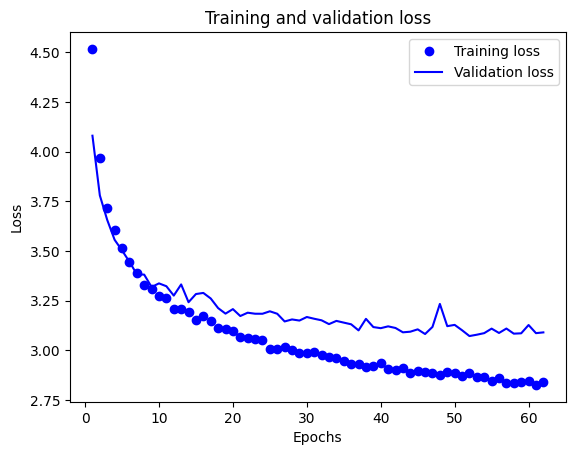

In [51]:
# Loss visualization
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()